# 2. Pharma sales Time Series predictions: DNN, LSTM, CNN, Prophet

The database used is from kaggle: https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data

It shows daily sales of drugs in 8 ATC categories, by a single pharmacy store over 6 years (last year incomplete).

In [1]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("milanzdravkovic/pharma-sales-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\drgui\.cache\kagglehub\datasets\milanzdravkovic\pharma-sales-data\versions\1


In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
csv_path = os.path.join(path, "salesdaily.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(df.shape)

      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
3  1/5/2014    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
4  1/6/2014    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday  
3   276       Sunday  
4   276       Monday  
(2106, 13)


Let's start by looking at the **daily sales of one drug**, for instance N05B - Psycholeptics drugs, Anxiolytic drugs.

In [4]:
# Convert date
df['datum'] = pd.to_datetime(df['datum'])

# Choose a single drug time series
drug_col = "N05B"   
ts = df.set_index('datum')[drug_col].sort_index()

print("Number of time points:", len(ts))
ts.head()

Number of time points: 2106


datum
2014-01-02     7.0
2014-01-03    16.0
2014-01-04    10.0
2014-01-05     8.0
2014-01-06    16.0
Name: N05B, dtype: float64

Let's divide our dataset in 3 and keep the test set identical to compare with our previous non ML models.

In [5]:
train_df = ts.iloc[:-600].to_frame()
val_df = ts.iloc[-600:-180].to_frame()
test_df = ts.iloc[-180:].to_frame()

We can start with a **DNN (deep neural network) as a single-step model**. 

In a single-step model, the
input is one timestep and the output is the prediction of the next timestep.

In [6]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history


column_indices = {name: i for i, name in enumerate(train_df.columns)}

Let's create a class for **data windowing**, a process in which we define a sequence of data points on our time
series and define which are inputs and which are labels. That way, the deep learning
model can fit on the inputs, generate predictions, compare them to the labels, and
repeat this process until it cannot improve the accuracy of its predictions.

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='N05B', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['N05B']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['N05B'])

In [9]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)
performance = {}
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 58.5294 - mean_absolute_error: 5.7769 - val_loss: 33.1964 - val_mean_absolute_error: 4.3843
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.0914 - mean_absolute_error: 4.8533 - val_loss: 32.1848 - val_mean_absolute_error: 4.3142
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.6675 - mean_absolute_error: 4.7515 - val_loss: 31.0725 - val_mean_absolute_error: 4.2383
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.2562 - mean_absolute_error: 4.6744 - val_loss: 29.7234 - val_mean_absolute_error: 4.1178
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.1689 - mean_absolute_error: 4.6322 - val_loss: 28.4522 - val_mean_absolute_error: 4.0326
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.4255 - mean_absolute_error: 4.4922 - val_loss: 27.2780 - val_mean_absolute_error: 3.9370
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.0258 - mean_absolute_error: 4.4214 - va

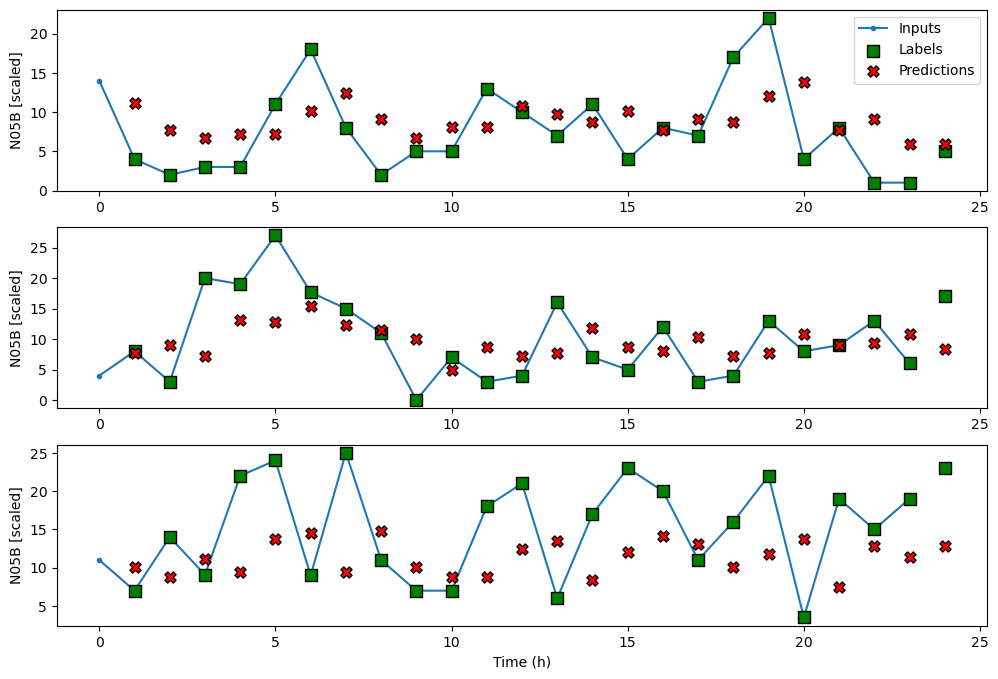

In [11]:
wide_window.plot(dense)

And now with a **Deep neural network as a multi-step model**: to predict the next 24 hours of sales based on the last 24 hours of
recorded data.

In [13]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['N05B'])

In [14]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

performance['DenseM'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 79.4650 - mean_absolute_error: 6.9177 - val_loss: 37.2109 - val_mean_absolute_error: 4.6466
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.8198 - mean_absolute_error: 5.4182 - val_loss: 35.5726 - val_mean_absolute_error: 4.5510
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.0433 - mean_absolute_error: 5.3205 - val_loss: 34.6170 - val_mean_absolute_error: 4.4907
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 49.4764 - mean_absolute_error: 5.2303 - val_loss: 33.0386 - val_mean_absolute_error: 4.3881
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.0274 - mean_absolute_error: 5.0839 - val_loss: 30.1130 - val_mean_absolute_error: 4.1953
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.2032 - mean_absolute_error: 4.8599 - val_loss: 26.0803 - val_mean_absolute_error: 3.9128
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.5027 - mean_absolute_error: 4.6314 - va

Let's compare the MAE beteen our different forecasting tools.

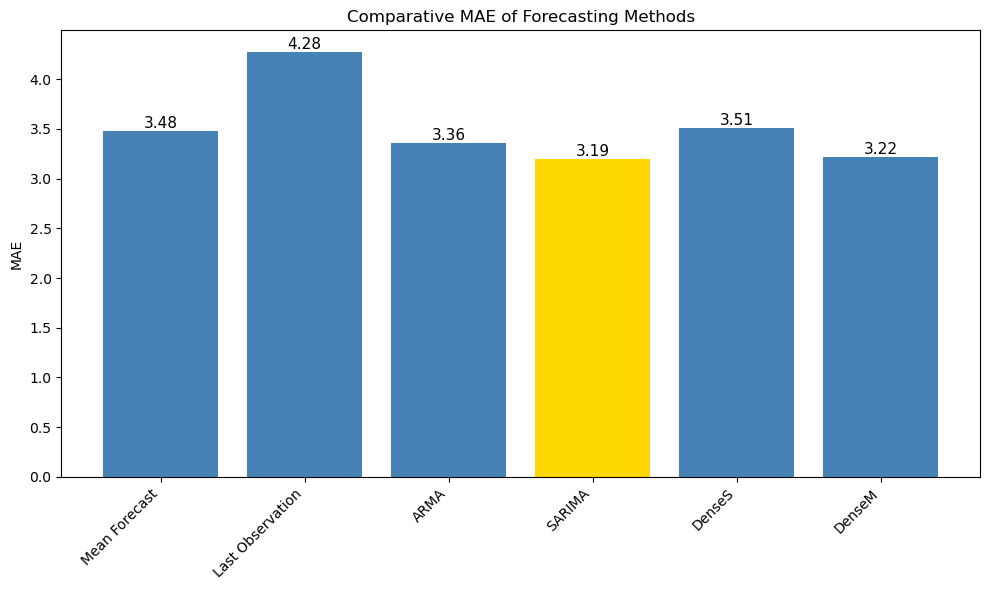

In [18]:
# MAE (Mean Forecast): 3.482663659682823
# MAE (Last Observation): 4.276666666666666
# MAE (ARMA Forecast): 3.357938986404366

mae_test = [3.482663659682823, 4.276666666666666, 3.357938986404366]

labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA','DenseS', 'DenseM']
values = [3.482663659682823, 4.276666666666666, 3.357938986404366, 3.1936315016498167,performance['Dense'] [1],performance['DenseM'] [1]]

# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SARIMA seem to be the best forecasting tool for now. Let's now try LSTM neural networks.

# Long short-term memory (LSTM)
It is a particular case of a recurrent neural network (RNN). It can be single or multi-step.


In [21]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

performance['LSTMS'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 70.4210 - mean_absolute_error: 6.2419 - val_loss: 33.7310 - val_mean_absolute_error: 4.2585
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.9284 - mean_absolute_error: 4.7222 - val_loss: 25.2973 - val_mean_absolute_error: 3.6897
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37.3464 - mean_absolute_error: 4.6291 - val_loss: 24.4400 - val_mean_absolute_error: 3.6416
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.9622 - mean_absolute_error: 4.5227 - val_loss: 24.2003 - val_mean_absolute_error: 3.6141
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 34.4415 - mean_absolute_error: 4.4047 - val_loss: 23.5911 - val_mean_absolute_error: 3.5881
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.4158 - mean_absolute_error: 4.3358 - val_loss: 23.6058 - val_mean_absolute_error: 3.5967
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32.6547 - mean_absolute_error: 4.2773 

In [22]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

performance['LSTMM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 105.5423 - mean_absolute_error: 8.3761 - val_loss: 79.0026 - val_mean_absolute_error: 7.7669
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78.8522 - mean_absolute_error: 6.7600 - val_loss: 51.5917 - val_mean_absolute_error: 5.8765
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.6600 - mean_absolute_error: 5.5197 - val_loss: 37.0472 - val_mean_absolute_error: 4.7067
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 47.9094 - mean_absolute_error: 4.9295 - val_loss: 28.9469 - val_mean_absolute_error: 4.0282
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42.0705 - mean_absolute_error: 4.6662 - val_loss: 24.5210 - val_mean_absolute_error: 3.6523
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.0054 - mean_absolute_error: 4.5636 - val_loss: 22.2606 - val_mean_absolute_error: 3.5139
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37.5071 - mean_absolute_error: 4.5338 

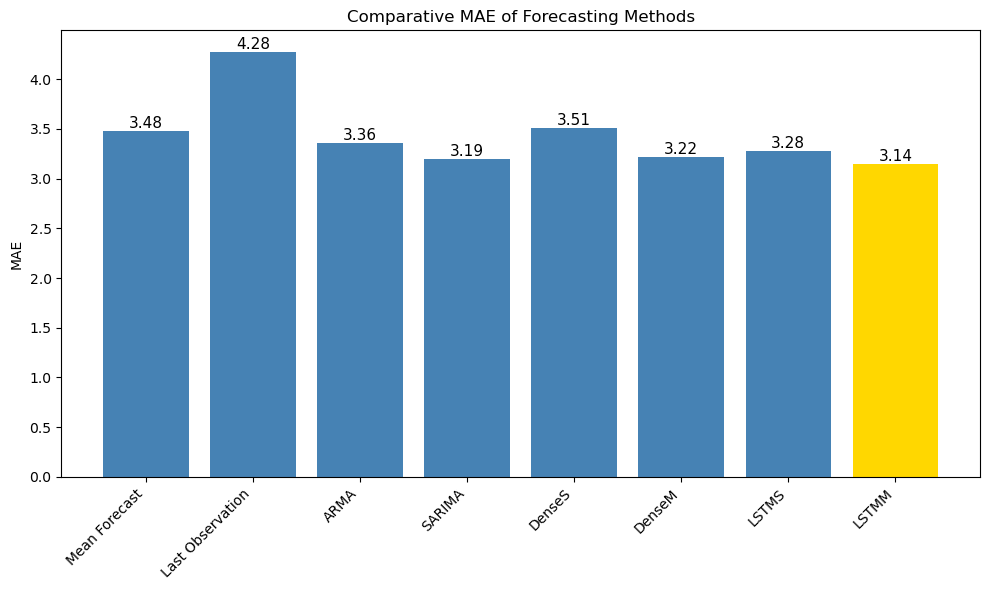

In [23]:
mae_test = [3.482663659682823, 4.276666666666666, 3.357938986404366]

labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA','DenseS', 'DenseM', 'LSTMS', 'LSTMM']
values = [3.482663659682823, 4.276666666666666, 3.357938986404366, 3.1936315016498167,performance['Dense'] [1],performance['DenseM'] [1],performance['LSTMS'] [1],performance['LSTMM'] [1]]

# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The multisteps LSSTM neural network shows now the lowest MAE.. Can CNN neural network do better?

# Using convolutional neural network (CNN)

In [24]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['N05B'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['N05B'])

In [25]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 69.4185 - mean_absolute_error: 6.3367 - val_loss: 29.8021 - val_mean_absolute_error: 4.2229
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.8100 - mean_absolute_error: 4.3881 - val_loss: 26.6252 - val_mean_absolute_error: 3.9730
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2924 - mean_absolute_error: 4.3153 - val_loss: 26.1150 - val_mean_absolute_error: 3.9455
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.8442 - mean_absolute_error: 4.2957 - val_loss: 25.7411 - val_mean_absolute_error: 3.9109
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.4836 - mean_absolute_error: 4.2872 - val_loss: 25.5206 - val_mean_absolute_error: 3.8871
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.3179 - mean_absolute_error: 4.2767 - val_loss: 25.4945 - val_mean_absolute_error: 3.8796
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.0362 - mean_absolute_error: 4.2490 - va

In [26]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 102.1384 - mean_absolute_error: 8.2043 - val_loss: 68.3315 - val_mean_absolute_error: 6.9014
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.7551 - mean_absolute_error: 5.3275 - val_loss: 29.8169 - val_mean_absolute_error: 3.9559
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38.0183 - mean_absolute_error: 4.5059 - val_loss: 23.9548 - val_mean_absolute_error: 3.5383
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.5925 - mean_absolute_error: 4.4855 - val_loss: 22.8707 - val_mean_absolute_error: 3.5001
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.1508 - mean_absolute_error: 4.5163 - val_loss: 22.6100 - val_mean_absolute_error: 3.4872
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.9209 - mean_absolute_error: 4.5104 - val_loss: 22.5019 - val_mean_absolute_error: 3.4778
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.5861 - mean_absolute_error: 4.4693 - 

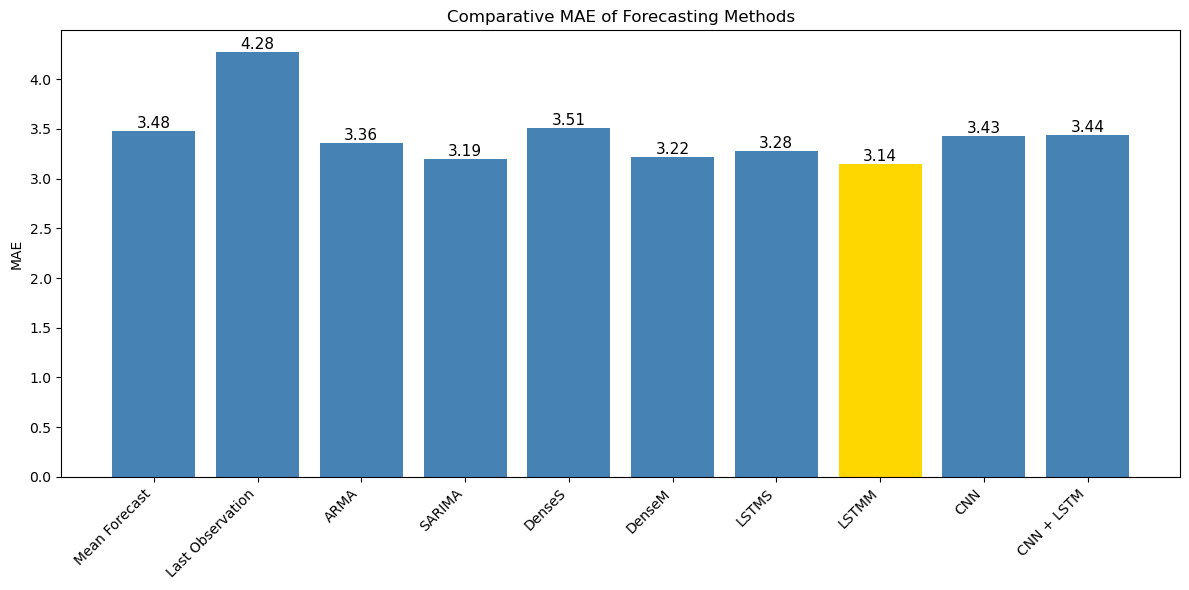

In [28]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA',
          'DenseS', 'DenseM', 'LSTMS', 'LSTMM',
          'CNN', 'CNN + LSTM']

values = [
    3.482663659682823,
    4.276666666666666,
    3.357938986404366,
    3.1936315016498167,
    performance['Dense'][1],
    performance['DenseM'][1],
    performance['LSTMS'][1],
    performance['LSTMM'][1],
    performance['CNN'][1],
    performance['CNN + LSTM'][1]
]

# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }  }

In [32]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['N05B'])

In [33]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)


performance['CNNM'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 93.2946 - mean_absolute_error: 7.6994 - val_loss: 44.2540 - val_mean_absolute_error: 5.3111
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 44.0164 - mean_absolute_error: 4.8828 - val_loss: 27.2126 - val_mean_absolute_error: 3.9844
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.7690 - mean_absolute_error: 4.7001 - val_loss: 26.3593 - val_mean_absolute_error: 3.9168
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.2758 - mean_absolute_error: 4.6776 - val_loss: 25.7113 - val_mean_absolute_error: 3.8677
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.6708 - mean_absolute_error: 4.6481 - val_loss: 25.5605 - val_mean_absolute_error: 3.8547
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.2247 - mean_absolute_error: 4.6186 - val_loss: 25.0669 - val_mean_absolute_error: 3.8149
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.6590 - mean_absolute_error: 4.5852 - va

In [42]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)
performance['CNN + LSTM M'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 102.5921 - mean_absolute_error: 8.2111 - val_loss: 72.9821 - val_mean_absolute_error: 7.4041
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 75.7189 - mean_absolute_error: 6.5758 - val_loss: 50.4685 - val_mean_absolute_error: 5.8232
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.6544 - mean_absolute_error: 5.5134 - val_loss: 37.2556 - val_mean_absolute_error: 4.7690
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 48.4677 - mean_absolute_error: 4.9434 - val_loss: 29.2424 - val_mean_absolute_error: 4.0872
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 42.4344 - mean_absolute_error: 4.6543 - val_loss: 24.5255 - val_mean_absolute_error: 3.6903
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39.0498 - mean_absolute_error: 4.5267 - val_loss: 21.8873 - val_mean_absolute_error: 3.4870
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37.2497 - mean_absolute_error: 4.4904 

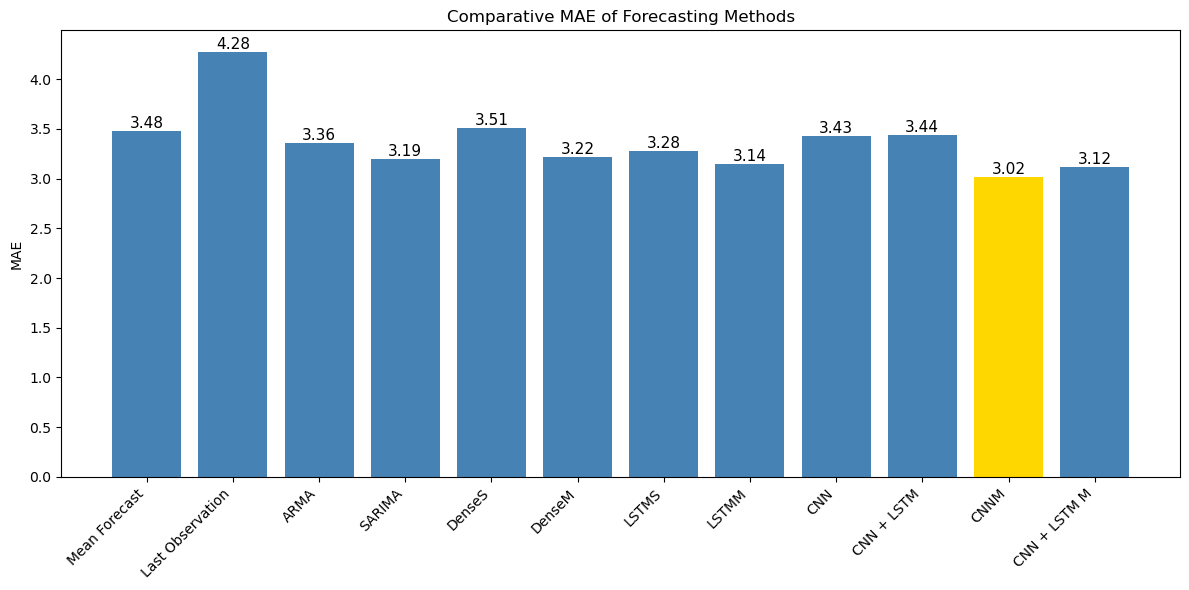

In [43]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA','DenseS', 'DenseM', 'LSTMS', 'LSTMM','CNN', 'CNN + LSTM','CNNM', 'CNN + LSTM M']
values = [3.482663659682823, 4.276666666666666, 3.357938986404366, 3.1936315016498167,performance['Dense'] [1],performance['DenseM'] [1],performance['LSTMS'] [1],performance['LSTMM'] [1],performance['CNN'] [1],performance['CNN + LSTM'] [1],performance['CNNM'] [1],performance['CNN + LSTM M'] [1]]


# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The CNN multistep model shows now the lowest MAE. Let's try autoregressive models.

In [59]:
from tensorflow.keras.layers import Conv1D, LSTMCell, RNN, Dense

class AutoRegressiveCNN(Model):
    def __init__(self, out_steps, kernel_width, conv_filters=32):
        super().__init__()
        self.out_steps = out_steps
        self.conv_filters = conv_filters

        # CNN encoder over the input window
        self.conv = Conv1D(filters=conv_filters, kernel_size=kernel_width, activation='relu')

        # Predict ONE step ahead (target)
        self.out = Dense(1, kernel_initializer=tf.initializers.zeros)

        # Project the previous prediction (1 dim) up to conv_filters so it can be fed back
        self.feedback = Dense(conv_filters)

        
    def warmup(self, inputs, training=None):
        """
        inputs: (batch, time, features)
        """
        x = self.conv(inputs, training=training)   # (batch, time', conv_filters)

        # Take the last timestep's conv features as the "state"
        state = x[:, -1, :]                        # (batch, conv_filters)

        prediction = self.out(state, training=training)  # (batch, 1)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []

        prediction, state = self.warmup(inputs, training=training)
        predictions.append(prediction)

        for _ in range(1, self.out_steps):
            # Feed back the previous prediction into the "state"
            state = self.feedback(prediction, training=training)  # (batch, conv_filters)

            prediction = self.out(state, training=training)       # (batch, 1)
            predictions.append(prediction)

        return tf.stack(predictions, axis=1)  # (batch, out_steps, 1)

In [60]:
OUT_STEPS = multi_window.label_width  # multi-step horizon

ar_cnn = AutoRegressiveCNN(
    out_steps=OUT_STEPS,
    kernel_width=KERNEL_WIDTH,
    conv_filters=32
)

history = compile_and_fit(ar_cnn, multi_window)
performance['CNN M (AR)'] = ar_cnn.evaluate(multi_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 110.8148 - mean_absolute_error: 8.6847 - val_loss: 93.4915 - val_mean_absolute_error: 8.6306
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84.3308 - mean_absolute_error: 7.2155 - val_loss: 22.5081 - val_mean_absolute_error: 3.6878
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.5176 - mean_absolute_error: 4.4413 - val_loss: 21.1090 - val_mean_absolute_error: 3.5107
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.1237 - mean_absolute_error: 4.3736 - val_loss: 21.5647 - val_mean_absolute_error: 3.5879
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.1584 - mean_absolute_error: 4.3914 - val_loss: 21.0151 - val_mean_absolute_error: 3.5088
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34.1556 - mean_absolute_error: 4.3865 - val_loss: 21.0707 - val_mean_absolute_error: 3.5239
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.2421 - mean_absolute_error: 4.3975 - 

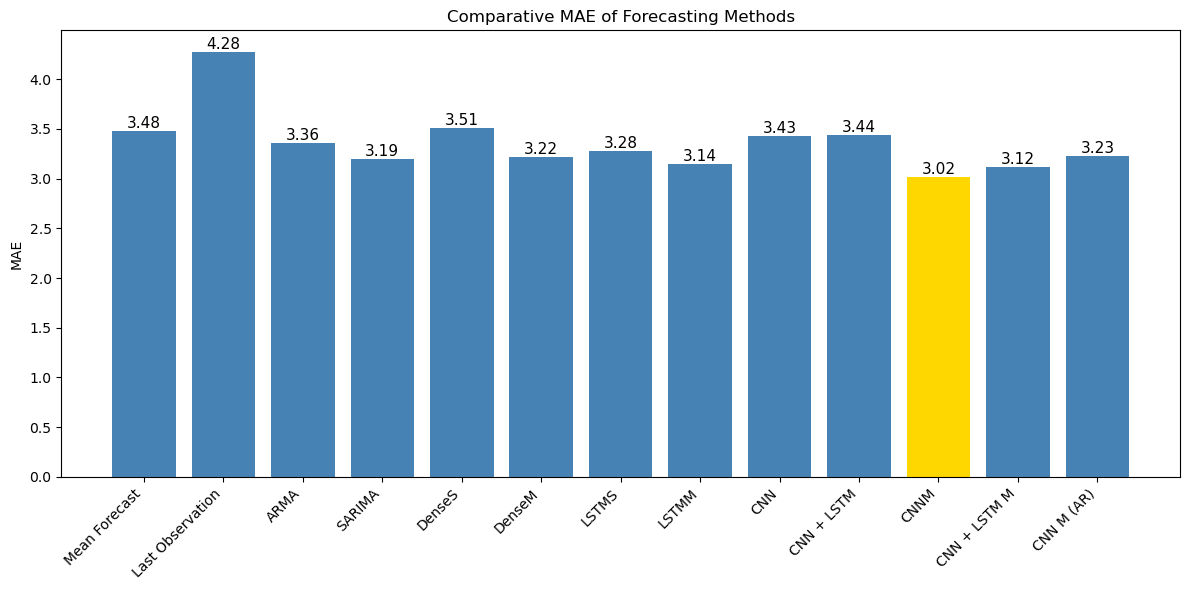

In [62]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA','DenseS', 'DenseM', 'LSTMS', 'LSTMM','CNN', 'CNN + LSTM','CNNM', 'CNN + LSTM M', 'CNN M (AR)']
values = [3.482663659682823, 4.276666666666666, 3.357938986404366, 3.1936315016498167,performance['Dense'] [1],performance['DenseM'] [1],performance['LSTMS'] [1],performance['LSTMM'] [1],performance['CNN'] [1],performance['CNN + LSTM'] [1],performance['CNNM'] [1],performance['CNN + LSTM M'] [1],performance['CNN M (AR)'] [1]]


# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

CNN multistep is still our best model. We can finally try Prophet, lon term and rolling forecasting.

In [44]:
from prophet import Prophet

In [82]:
ts.head()

datum
2014-01-02     7.0
2014-01-03    16.0
2014-01-04    10.0
2014-01-05     8.0
2014-01-06    16.0
Name: N05B, dtype: float64

In [45]:
tsp = ts.reset_index()
tsp.columns = ['ds', 'y']
tsp.head()

,ds,y
0,2014-01-02,7.0
1,2014-01-03,16.0
2,2014-01-04,10.0
3,2014-01-05,8.0
4,2014-01-06,16.0


In [46]:
train = tsp[:-180]
test = tsp[-180:]

In [50]:
import cmdstanpy
cmdstanpy.install_cmdstan()

CmdStan install directory: C:\Users\drgui\.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: C:\Users\drgui\AppData\Local\Temp\tmpuignamhk
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.


12:47:20 - cmdstanpy - WARNING - CmdStan installation failed.
Command "make build" failed
Command ['mingw32-make', 'build', '-j1']
	exited with code '2' No such file or directory


False

In [54]:
from prophet import Prophet

m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)

# Use LBFGS (much more stable than Newton on many datasets)
m.fit(train)

13:35:28 - cmdstanpy - INFO - Chain [1] start processing
13:35:28 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
from sklearn.metrics import mean_absolute_error
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
print(prophet_mae)

3.4622307194937725


In [64]:
window = 7
history = train.copy()
preds = []

i = 0
while i < len(test):
    m = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    m.fit(history)

    steps = min(window, len(test) - i)
    future = m.make_future_dataframe(periods=steps)
    yhat = m.predict(future).iloc[-steps:]['yhat'].values
    preds.extend(yhat)

    history = pd.concat([history, test.iloc[i:i+steps]])
    i += steps

future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)

# Keep only the forecast rows that match the test dates
fc_test = forecast.set_index('ds').loc[test['ds']]

test = test.copy()
test[['yhat', 'yhat_lower', 'yhat_upper']] = fc_test[['yhat', 'yhat_lower', 'yhat_upper']].values

from sklearn.metrics import mean_absolute_error
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
print(prophet_mae)

14:36:53 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:54 - cmdstanpy - INFO - Chain [1] start processing
14:36:54 - cmdstanpy - INFO - Chain [1] done processing
14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:36:55 - cmdstanpy - INFO - Chain [1] done processing
14:36:56 - cmdstanpy - INFO - Chain [1] start processing
14:36:56 - cmdstanpy - INFO - Chain [1] done processing
14:36:56 - cmdstanpy - INFO - Chain [1] start processing
14:36:56 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing
14:36:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:58 - cmdstanpy - INFO - Chain [1] done processing
14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1]

3.2326834709778156


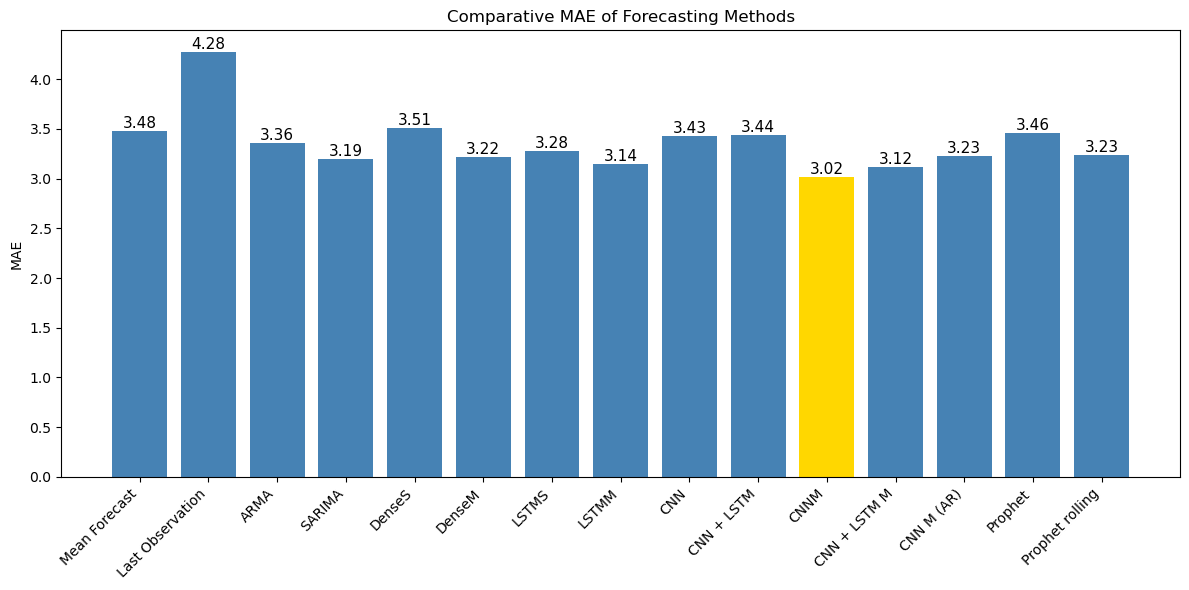

In [65]:
labels = ['Mean Forecast', 'Last Observation', 'ARMA', 'SARIMA','DenseS', 'DenseM', 'LSTMS', 'LSTMM','CNN', 'CNN + LSTM','CNNM', 'CNN + LSTM M', 'CNN M (AR)','Prophet', 'Prophet rolling']
values = [3.482663659682823, 4.276666666666666, 3.357938986404366, 3.1936315016498167,performance['Dense'] [1],performance['DenseM'] [1],performance['LSTMS'] [1],performance['LSTMM'] [1],performance['CNN'] [1],performance['CNN + LSTM'] [1],performance['CNNM'] [1],performance['CNN + LSTM M'] [1],performance['CNN M (AR)'] [1],3.4622307194937725, 3.2326834709778156]


# Find index of lowest MAE
min_idx = np.argmin(values)

# Set colors (green for best, blue for others)
colors = ['gold' if i == min_idx else 'steelblue' for i in range(len(values))]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.ylabel("MAE")
plt.title("Comparative MAE of Forecasting Methods")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In this case, **CNN multistep** seem the best forecasting model.

### References
* https://www.kaggle.com/code/milanzdravkovic/pharma-sales-data-analysis-and-forecasting/notebook
* Time Series Forecasting in Python, Marco Peixeiro. Manning. 2022